## **Import de packages**

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.models import *
from keras.layers import *
import os
# Suppression de la journalisation de Tensorflow ( 3 designe afficher que les erreurs critiques )
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import cv2  # Importer OpenCV pour le traitement d'images

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# **Génération des images :**

# **Importation des donnees:**

* On va collecter tout d'abord les chemins d'accès des images de radiographies thoraciques à partir des sous-répertoires spécifiés.
Par exemple, 'train/NORMAL', 'train/PNEUMONIA', 'test/NORMAL', 'test/PNEUMONIA'

**Quelques étapes le prétraitement :**

**-Rendre les images de même dimension(224*224 pixels)**

* Nos images sont de dimensions differentes donc il faut les transformer en une seule dimension pour effectuer la tâche.  


**-Normalisation des valeurs de pixels**

* **rescale=1./255 :**  Cette option normalise les valeurs des pixels des images en les mettant à l'échelle de [0, 255] à [0, 1]. C'est une étape commune pour la prétraitement des images dans les réseaux de neurones pour assurer que toutes les entrées ont une échelle similaire.
-> rendre les valeurs d'entrée plus homogènes

In [3]:
# Définir le chemin général
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# Normalisation des images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen1 = ImageDataGenerator(rescale=1./255)

# Charger les images
train_generator = train_datagen.flow_from_directory(directory=path +'train',
                                                    target_size=(224, 224), #rendre les images de même dimension(224*224 pixels)
                                                    classes=['NORMAL','PNEUMONIA'], #les noms des sous-dossiers
                                                    color_mode="grayscale",
                                                    batch_size=32,# les images seront traitées par lots de 32.
                                                    class_mode=None,
                                                    shuffle=True,#Mélanger les images dealéatoirement à chaque époque
                                                    seed=1234)


test_generator = test_datagen.flow_from_directory(directory=path +'test',
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  classes=['NORMAL','PNEUMONIA'],
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=1234)
test_generator1 = test_datagen1.flow_from_directory(directory=path +'test',
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  classes=['NORMAL','PNEUMONIA'],
                                                  batch_size=1,
                                                  class_mode="binary", #les étiquettes seront retournées par le générateur
                                                  shuffle=False,
                                                  seed=1234)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


* On stocke ensuite ces chemins dans des DataFrames pour la partie EDA (Exploratory Data Analysis ).

In [4]:
# Créer un DataFrame à partir du générateur de données d'entraînement

train_df = pd.DataFrame(train_generator.labels, columns=['labels'])
train_df['filename'] = train_generator.filenames   #Récupère les chemins des fichiers des images à partir du générateur
train_df['filename'] = train_df['filename'].apply(lambda x: x.split('/')[-1])   #Extraction des noms de fichiers des chemins


# Créer un DataFrame à partir du générateur de données de test
test_df = pd.DataFrame(test_generator.labels, columns=['labels'])
test_df['filename'] = test_generator.filenames
test_df['filename'] = test_df['filename'].apply(lambda x: x.split('/')[-1])



# **EDA**

## **Dimensions du dataset**

In [5]:
print(f"""
AFFICHAGE DES DIMENSIONS:
_________________________

  TRAIN DATASET:

    train_healthy: {len(train_df[train_df["labels"]==0])} NORMAL images

    train_pneumon: {len(train_df[train_df["labels"]==1])} PNEUMONIA images

***************************************************************

  TEST DATASET :

    test_healthy: {len(test_df[test_df["labels"]==0])} NORMAL images

    test_pneumon: {len(test_df[test_df["labels"]==1])} PNEUMONIA images

""")


AFFICHAGE DES DIMENSIONS:
_________________________

  TRAIN DATASET:

    train_healthy: 1341 NORMAL images

    train_pneumon: 3875 PNEUMONIA images

***************************************************************

  TEST DATASET :

    test_healthy: 234 NORMAL images

    test_pneumon: 390 PNEUMONIA images




# **Visualisation des Images de differentes classes**

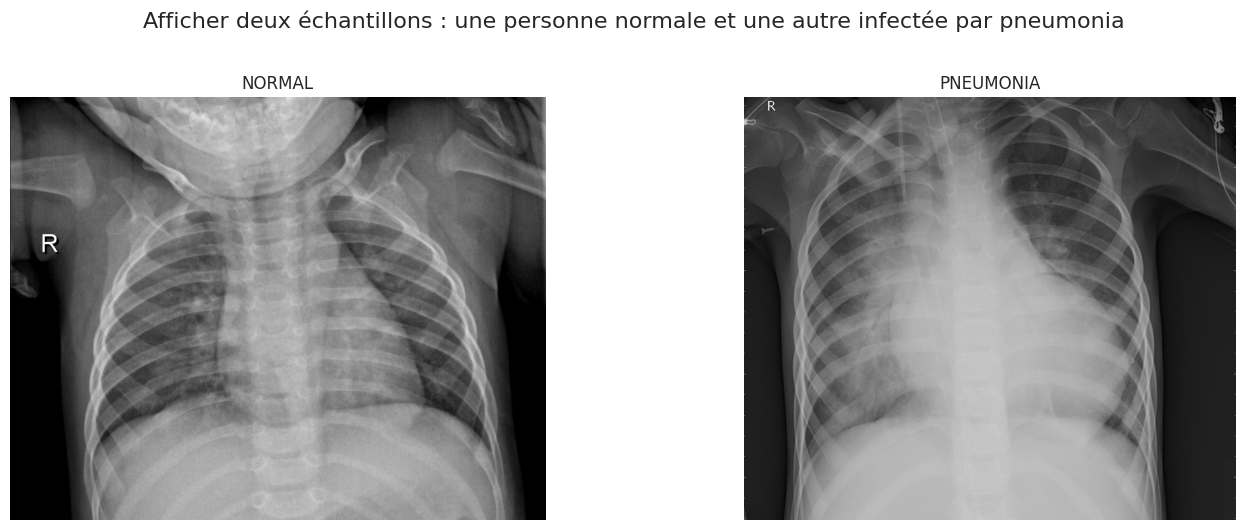

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# Lire une image NORMAL en mode niveaux de gris à partir du DataFrame train_healthy_df
normal_img = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/"+train_df[train_df["labels"]==0].iloc[8]['filename'], cv2.IMREAD_GRAYSCALE)
axes[0].imshow(normal_img, cmap='gray')
axes[0].set_title("NORMAL")
axes[0].axis('off')

# Lire une image infecte de PNEUMONIA en mode niveaux de gris à partir du DataFrame train_pneumon_df
pneumonia_img = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/"+train_df[train_df["labels"]==1].iloc[4]['filename'], cv2.IMREAD_GRAYSCALE)
axes[1].imshow(pneumonia_img, cmap='gray')
axes[1].set_title("PNEUMONIA")
axes[1].axis('off')


# Ajuster la mise en page pour s'assurer que le titre global n'empiète pas sur les sous-graphes
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Ajouter un titre global à la figure
plt.suptitle("Afficher deux échantillons : une personne normale et une autre infectée par pneumonia", y=1.05, fontsize=16)


plt.show()

# **Distribution des classes entre les personnes**

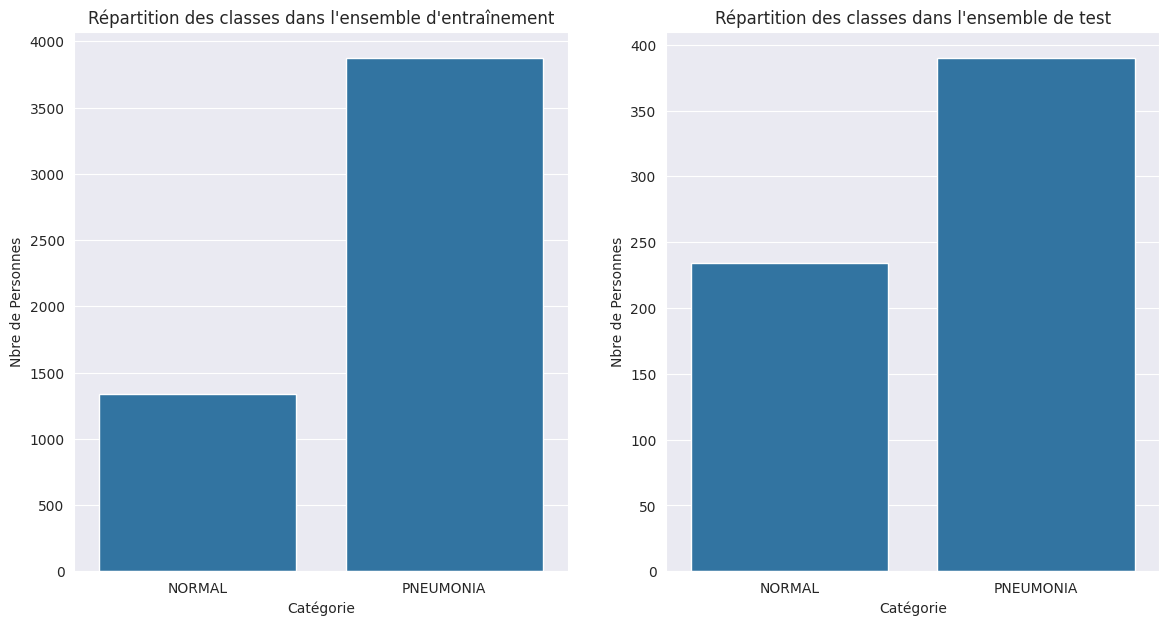

In [ ]:
train_labels = ["PNEUMONIA" if label == 1 else "NORMAL" for label in train_df["labels"]]
test_labels = ["PNEUMONIA" if label == 1 else "NORMAL" for label in test_df["labels"]]

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(14, 7))


sns.countplot(x=train_labels, ax=axs[0])
axs[0].set_title('Répartition des classes dans l\'ensemble d\'entraînement')
axs[0].set_xlabel('Catégorie')
axs[0].set_ylabel('Nbre de Personnes')

sns.countplot(x=test_labels, ax=axs[1])
axs[1].set_title('Répartition des classes dans l\'ensemble de test')
axs[1].set_xlabel('Catégorie')
axs[1].set_ylabel('Nbre de Personnes')
plt.show()

In [ ]:
train_df['labels'].value_counts()

labels
1    3875
0    1341
Name: count, dtype: int64

# **Construction du modéle**

* **Encodeur :**

On a une série de trois couches de convolution (Conv2D) suivies de couches de mise en commun (MaxPooling2D) pour réduire progressivement les dimensions de l'entrée, en extrayant les caractéristiques importantes.

**Conv2D :** Couche de convolution avec 32 filtres de taille (3, 3) pour extraire des caractéristiques importantes de l'image, suivie d'une fonction d'activation ReLU (qui permet d'introduire la non-linéarité en activant seulement les valeurs positives et en désactivant les valeurs négatives).

**MaxPooling2D :** Couche de mise en commun qui réduit de moitié la taille de l'image en conservant les caractéristiques les plus importantes.


* **Décodeur** :

Le bloc de décodeur utilise des couches de convolution et de mise en commun transposées pour reconstruire l'image à partir des caractéristiques extraites par l'encodeur.


**UpSampling2D :** Couche qui double la taille de l'image en répétant les valeurs.



In [ ]:
# Définir l'autoencodeur
input_img = Input(shape=(224, 224, 1))  #1 indique qu'il s'agit d'images en niveaux de gris,

# Encodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Décodeur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Créer le modèle
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
   #Adam ajuste dynamiquement le taux d'apprentissage pour chaque paramètre,
   #favorisant une convergence rapide et une gestion efficace des taux d'apprentissage disparates.


# Afficher le résumé du modèle
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 128)       7385

# **Entrainement du modele**

In [ ]:
# Définir un générateur personnalisé pour renvoyer les entrées et les cibles
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        # Calculer la longueur en fonction du nombre de lots
        return len(self.generator)

    def __getitem__(self, index):
        # retourner les entrées et les cibles
        batch_x = self.generator[index]
        return batch_x, batch_x


# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#Le EarlyStopping est un callback qui permet d'arrêter l'entraînement si la performance sur
# l'ensemble de validation ne s'améliore pas après un certain nombre d'époques (patience). 
#Il restaure également les poids du modèle à l'état où la performance de validation était la meilleure.



# active l'exécution immédiate, ce qui permet de déboguer plus facilement le code TensorFlow.
tf.config.run_functions_eagerly(True)


#Création du générateur d'entraînement pour les données normales
train_normal_generator = train_datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),
    color_mode="grayscale",
    classes=['NORMAL'],
    batch_size=32,
    class_mode=None,
    shuffle=True,
    seed=1234
)
train_normal_data_gen = DataGenerator(train_normal_generator)

#Création du générateur de données de test :
test_data_gen = DataGenerator(test_generator)


#Calcul des étapes d'entraînement et de test (en divisant le nombre total d'images par la taille des lots) :

STEP_SIZE_TRAIN =  train_normal_generator.n//train_normal_generator.batch_size
STEP_SIZE_TEST =  test_generator.n//test_generator.batch_size

# Entraîner le modèle uniquement sur les données normales pendant un maximum de 10 époques.
history1 = autoencoder.fit(
    train_normal_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=10,
    validation_data=test_data_gen,  # Utiliser l'ensemble de test pour la validation
    validation_steps=STEP_SIZE_TEST,
    callbacks=[early_stop]
)

Found 1341 images belonging to 1 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


41/41 [==============================] - 530s 13s/step - loss: 0.0260 - val_loss: 0.0056
Epoch 2/10
41/41 [==============================] - 524s 13s/step - loss: 0.0050 - val_loss: 0.0034
Epoch 3/10
41/41 [==============================] - 506s 12s/step - loss: 0.0038 - val_loss: 0.0026
Epoch 4/10
41/41 [==============================] - 528s 13s/step - loss: 0.0032 - val_loss: 0.0025
Epoch 5/10
41/41 [==============================] - 531s 13s/step - loss: 0.0028 - val_loss: 0.0021
Epoch 6/10
41/41 [==============================] - 531s 13s/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/10
41/41 [==============================] - 530s 13s/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/10
41/41 [==============================] - 530s 13s/step - loss: 0.0022 - val_loss: 0.0017
Epoch 9/10
41/41 [==============================] - 508s 12s/step - loss: 0.0022 - val_loss: 0.0017
Epoch 10/10
41/41 [==============================] - 507s 12s/step - loss: 0.0020 - val_loss: 0.0016


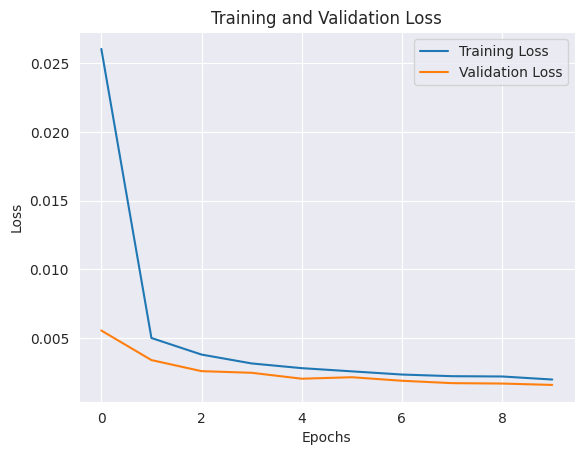

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history["loss"], label="Training Loss")
plt.plot(history1.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### **Interpretation**
* Les pertes d'entraînement et de validation diminuent toutes les deux au fil du temps. **==>** Cela indique que le modèle apprend et améliore ses performances sur les ensembles de données d'entraînement et de validation.

* La perte d'entraînement commence plus élevée et diminue plus rapidement au début, puis se stabilise progressivement.

* La perte de validation diminue également et suit un schéma similaire, restant proche de la perte d'entraînement tout au long des époques.

* Le fait que la perte de validation suive de près la perte d'entraînement sans écart significatif suggère que le modèle ne surapprend pas. **==> Pas de surapprentissage**


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Récupérer toutes les images d'entraînement normal depuis le générateur
train_normal_data = []
for i in range(len(train_normal_data_gen)):
    images = train_normal_data_gen[i]
    # Vérifier si images est un tuple (images, labels) et récupérer les images
    if isinstance(images, tuple):
        images = images[0]
    train_normal_data.append(images)

# Convertir la liste d'images en un tableau NumPy
train_normal_data = np.concatenate(train_normal_data, axis=0)

# Générer des reconstructions pour les données d'entraînement normal
reconstructions = autoencoder.predict(train_normal_data)

# Calculer la perte de reconstruction (MSE) entre les reconstructions et les données d'entraînement originales
train_loss = tf.keras.losses.mean_squared_error(train_normal_data, reconstructions)
print(train_loss)
mean_train_loss = np.mean(train_loss)
std_train_loss = np.std(train_loss)
threshold = mean_train_loss + std_train_loss
print("Threshold: ", threshold)



42/42 [==============================] - 109s 3s/step
tf.Tensor(
[[[1.09905777e-02 2.76617054e-03 4.98598150e-04 ... 8.58580024e-05
   2.29846803e-03 4.50294651e-02]
  [2.06274795e-03 2.19077757e-03 1.58513103e-05 ... 1.12708437e-03
   1.95557103e-02 5.77879250e-02]
  [1.02538220e-03 1.02356169e-03 5.51756493e-05 ... 7.23417266e-04
   6.93729594e-02 3.46100777e-02]
  ...
  [4.57113143e-04 1.20293174e-04 2.75282000e-05 ... 2.40137288e-05
   6.42397790e-05 7.31036242e-04]
  [1.38967682e-03 3.81522637e-04 1.16401185e-04 ... 9.62237973e-05
   1.97766465e-04 2.16752081e-03]
  [1.84878763e-02 3.55339726e-03 1.56199583e-03 ... 9.22641542e-04
   2.02477723e-03 9.49221104e-03]]

 [[1.72782708e-02 9.94974561e-03 8.45001079e-04 ... 4.19358723e-03
   4.44327155e-03 7.29848305e-03]
  [4.30627633e-03 4.96993831e-04 6.96024799e-04 ... 1.88187449e-04
   1.92625434e-04 3.92968446e-04]
  [1.69398508e-03 1.30279420e-03 1.01702899e-04 ... 3.55602265e-06
   2.80383072e-04 1.08150642e-04]
  ...
  [2.9525178

### ==>  **Threshold:**  0.012642836

In [ ]:
test_data = []
test_labels = []

# Itérer sur le générateur de données de test
for images, labels in test_generator1:
    # Ajouter les images et les étiquettes aux listes correspondantes
    test_data.append(images)
    test_labels.append(labels)

    # Arrêter la boucle si toutes les données ont été collectées
    if len(test_data) == len(test_generator1):
        break

# Convertir les listes en tableaux numpy
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

test_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

1/1 [==============================] - 0s 325ms/step


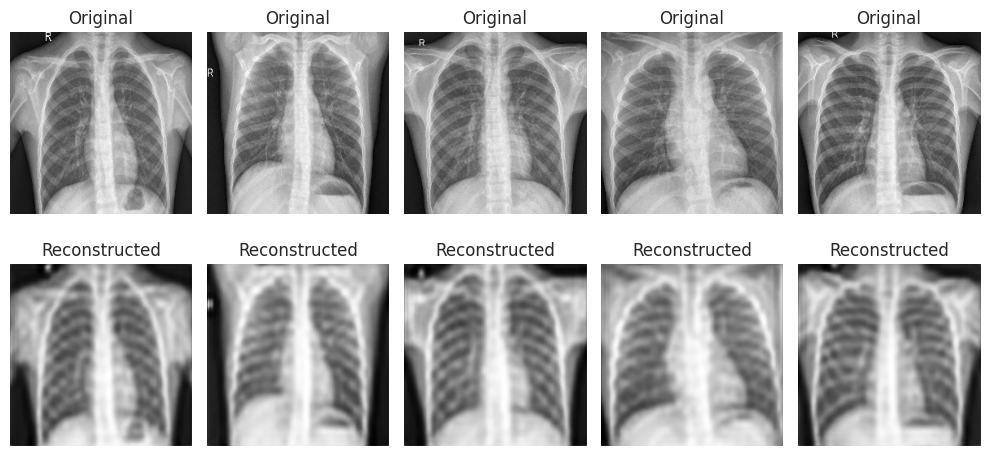

In [ ]:
import matplotlib.pyplot as plt

# Sélectionner quelques images de votre ensemble de données de test
num_images = 5
sample_images = test_data[:num_images]

# Utiliser le modèle autoencodeur pour reconstruire les images
reconstructed_images = autoencoder.predict(sample_images)

# Afficher les images originales et reconstruites
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Image originale
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i].reshape(224, 224), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Image reconstruite
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(reconstructed_images[i].reshape(224, 224), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


On va developper maintenant une fonction pour prédire les anomalies basées sur la perte de reconstruction etant donnée le modele, data et le seuil.

Elle retourne un tableau numpy contenant les prédictions binaires

        Si la perte moyenne est inférieure au seuil --> l'image est considérée comme normale et la prédiction est 0.
        
        Sinon  --> l'image est considérée comme anormale et la prédiction est 1..


In [ ]:
def predict(model, data, threshold):

    reconstructions = model.predict(data)
    losses = tf.keras.losses.mean_squared_error(data, reconstructions)
    mean_losses = np.mean(losses, axis=(1, 2))  # Calculer la perte moyenne par image

    predictions = mean_losses < threshold
    return predictions.astype(int)

In [ ]:
# Fonction pour afficher les statistiques de performance
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("F1 score = {}".format(f1_score(labels, predictions)))

In [ ]:
predictions = predict(autoencoder, test_data, threshold)

# Afficher les mesures de performance
print_stats(predictions, test_labels)

20/20 [==============================] - 52s 3s/step
Accuracy = 0.625
Precision = 0.625
Recall = 1.0
F1 score = 0.7692307692307693
